<a href="https://colab.research.google.com/github/mateosuster/nlpPapers/blob/main/code/07_LDA_experimento_n_topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencias

In [ ]:
%%capture
!pip install pyLDAvis==2.1.2

import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
from collections import Counter
import numpy as np
from nltk import word_tokenize, sent_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim import corpora

from google.colab import files

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import os, re, operator, warnings, time
warnings.filterwarnings('ignore')  
%matplotlib inline

# Data

In [ ]:
Tipo_Datos = "sampleados"  ##### ELIJA: "totales" O "sampleados".

from pandas.core.describe import describe_categorical_1d
data_Total = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/ACL_data.csv")
data_Sampleada = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/data_clean.csv")

if Tipo_Datos == "sampleados":
  data = data_Sampleada
elif Tipo_Datos == "totales":
  data = data_Total
data



,text
0,used think output translation machine would st...
1,program determination divided routines analysi...
2,statistical study made extent russian nouns en...
3,paper concerned use electrical networks automa...
4,les recherches depuis quelques en vue de la tr...
...,...
18575,recent years witnessed emergence variety inter...
18576,patronizing condescending language pcl large h...
18577,language models plms shown great potentials na...
18578,named entity recognition ner aims borrow entit...


In [ ]:
if Tipo_Datos == "sampleados":
  dataset = data.text.tolist()
elif Tipo_Datos == "totales":
  dataset = data.ABSTRACT
  dataset = dataset.tolist()
dataset[0]

'used think output translation machine would stylistically inelegant would tolerable message got across find getting message across accurately difficult may able stylistic elegance output since much style reflects depth phenomena thus systematic example order clauses many twoclause sentences reversed without change meaning normally true sentences two clauses meaning usually changes clause order changed equivalently appear severe restrictions clause order given meaning restrictions appear follow depth considerations idea investigated normal clause order deviations order must signalled special syntactic semantic devices nature devices explored translating sentences may trouble due fact clause types two languages exactly parallel therefore list allowed preferred clause orders two languages equivalent special syntactic semantic devices available signal deviations normal order different thus one would predict sentences language often split two sentences translated language time sentences la

In [ ]:
type(dataset)


list

# Preproc

## Limpieza

In [ ]:
STOP_WORDS = stopwords.words("english")

def tokenize(x):
    return [word for word in word_tokenize(x) if word not in STOP_WORDS and word.isalpha() and len(word)>1]

if Tipo_Datos == "sampleados":
  texts = [word_tokenize(str(doc)) for doc in dataset]
elif Tipo_Datos == "totales":
  texts= [tokenize(str(doc).lower()) for doc in dataset]

In [ ]:
print(texts[100])

['efficient', 'algorithm', 'enumerates', 'parses', 'ambiguous', 'languages', 'described', 'time', 'space', 'complexities', 'discussed', 'parsers', 'used', 'natural', 'language', 'parsing', 'pattern', 'recognition', 'forth', 'may', 'great', 'number', 'parses', 'sentence', 'one', 'common', 'strategy', 'efficient', 'enumeration', 'parses', 'assign', 'appropriate', 'weight', 'production', 'enumerate', 'parses', 'order', 'total', 'weight', 'applied', 'production', 'however', 'existing', 'algorithms', 'taking', 'strategy', 'applied', 'problems', 'limited', 'areas', 'regular', 'languages', 'areas', 'inefficient', 'exhaustive', 'searches', 'known', 'paper', 'first', 'introduce', 'hierarchical', 'graph', 'suitable', 'enumeration', 'using', 'graph', 'enumeration', 'parses', 'order', 'acceptablity', 'equivalent', 'finding', 'paths', 'graph', 'order', 'length', 'present', 'efficient', 'enumeration', 'algorithm', 'graph', 'applied', 'arbitrary', 'grammars', 'enumeration', 'parses', 'order', 'total'

## Ajustes para LDA

In [ ]:
### dictionary:
dictionary = corpora.Dictionary(texts)  #crea diccionario asinandole un indice numerico a cada palabra
print(len(dictionary))

dictionary.filter_extremes(no_below=10, no_above=0.5)  #filtra tokens q aparencen en menos de 10 documentos y en mas de la mitad de los documentos.
print(len(dictionary))

#Documentacion de filter_extremes: https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.filter_extremes.html

### doc2bow:
corpus = [dictionary.doc2bow(text) for text in texts] #el bow cuenta cantidad de apariciones de cada palabra del diccionario
len(corpus) 

37032
7924


18580

## ***Análisis fino de la cant. óptima de Topics:***

## **Grid Search Automático:**
#### ***Setee parámetros de búsqueda:***
#### - *Cantidad mínima de Topics a evaluar  (=2).*
#### - *Cantidad máxima de Topics a evaluar  (=60).*
#### - ***Step (=1).***

##### *Setee parámetros de evaluación:*
##### - *Windows size  (=10).*
##### - *Tipo de métrica de Coherencia  (='c_npmi').*
##### - *Top Words/Topic to evaluate (=30).*

In [ ]:
################# GRID SEARCH ###############################
#### ANALIZADOR DE CANTIDAD OPTIMA DE TOPICOS, POR COMPARACION DE COHERENCIAS TOTALES Y PROMEDIO:
#### SOLO LO HAREMOS CON EL MODELO LDA CON BOW VECTOR, DADO QUE RESULTO MEJOR Q EL LSI Y EL TD-IDF:
inicio = time.time()

Cant_Topics_Min = 2   # INGRESE CANTIDAD MINIMA DE TOPICOS
Cant_Topics_Max = 25  # INGRESE CANTIDAD MAXIMA DE TOPICOS
Step = 1              # INGRESE STEP

n_semillas = 5

window_size_=10     # INGRESE COHERENCIA WINDOW_SIZE 
coherence_='c_npmi' # INGRESE METRICA DE COHERENCIA 
topn_=30            # INGRESE COHERENCIA TOP WORDS TO EVALUATE. 
Grid_Search = range(Cant_Topics_Min, Cant_Topics_Max + Step, Step)  


Coherence_Total_array = []
Coherence_Media_array = []
Coherence_MediaPond_array = []
N_Topics_array = []
semillas_array = []

for n_topics in Grid_Search:
  print(f'Entrenando modelos con {n_topics} topicos')
  for i in range(n_semillas):
    print(f'Iteracion numero {i}')
    semilla = 420 + i
    np.random.seed(semilla)

    ldamodel = LdaModel(corpus=corpus, num_topics=n_topics, id2word=dictionary, iterations = 200, passes=10, random_state=semilla)
    ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(n_topics,formatted=False)]
    lda_coherence = CoherenceModel(topics=ldatopics, texts=texts, dictionary=dictionary, 
                                   window_size=window_size_,coherence=coherence_,topn=topn_).get_coherence_per_topic()
    
    
    Coherence_Total_array.append(sum(lda_coherence))
    Coherence_Media_array.append(np.mean(lda_coherence))
    Coherence_MediaPond_array.append(np.mean(lda_coherence) / sum(lda_coherence) )
    N_Topics_array.append(n_topics)
    semillas_array.append(semilla)

fin = time.time()
print(fin-inicio)

df = pd.DataFrame(list(zip(Coherence_Total_array , Coherence_Media_array , Coherence_MediaPond_array,  
                           N_Topics_array , semillas_array )),
               columns =['coh_tot', 'coh_avg', 'coh_avg_pond', 'topics', 'seed'])
df.to_csv('/content/experiment_n_topic.csv', index= False)

files.download('/content/experiment_n_topic.csv')

Entrenando modelos con 2 topicos
Iteracion numero 1
Iteracion numero 2
Iteracion numero 3
Iteracion numero 4
Iteracion numero 5
Iteracion numero 6
Iteracion numero 7
Iteracion numero 8
Iteracion numero 9
Iteracion numero 10
Entrenando modelos con 3 topicos
Iteracion numero 1
Iteracion numero 2
Iteracion numero 3
Iteracion numero 4
Iteracion numero 5
Iteracion numero 6
Iteracion numero 7
Iteracion numero 8
Iteracion numero 9
Iteracion numero 10
Entrenando modelos con 4 topicos
Iteracion numero 1
Iteracion numero 2
Iteracion numero 3
Iteracion numero 4
Iteracion numero 5
Iteracion numero 6
Iteracion numero 7
Iteracion numero 8
Iteracion numero 9
Iteracion numero 10
Entrenando modelos con 5 topicos
Iteracion numero 1
Iteracion numero 2
Iteracion numero 3
Iteracion numero 4
Iteracion numero 5
Iteracion numero 6
Iteracion numero 7
Iteracion numero 8
Iteracion numero 9
Iteracion numero 10
Entrenando modelos con 6 topicos
Iteracion numero 1
Iteracion numero 2
Iteracion numero 3
Iteracion nume

In [ ]:
Coherence_Total_array

NameError: ignored

In [ ]:
#### TRAIGO A MANO LOS RESULTADOS, PARA GRAFICAR, PORQUE SE CAYO EL COLAB ANTES DE TERMINAR:
"""N_Topics_array = pd.read_excel("n_Topics.xlsx")
N_Topics_array.head()
N_Topics_array = N_Topics_array["n_Topics"].tolist()

Coherence_Total_array = pd.read_excel("LDA_Total_Coherence.xlsx")
Coherence_Total_array.head()
Coherence_Total_array = Coherence_Total_array["LDA Total Coherence"].tolist()

Coherence_Media_array = pd.read_excel("LDA_Mean_Coherence.xlsx")
Coherence_Media_array.head()
Coherence_Media_array = Coherence_Media_array["LDA Mean Coherence"].tolist()

print(type(N_Topics_array))
print(len(N_Topics_array))
print(type(Coherence_Total_array))
print(len(Coherence_Total_array))
print(type(Coherence_Media_array))
print(len(Coherence_Media_array))"""

<class 'list'>
49
<class 'list'>
49
<class 'list'>
49


## **Gráficos de evolución de la Coherencia Media y Total en función de la cant. de Topics: Analisis de granularidad fina (Step=1)**
#### ***Setee parámetros visualización:***
#### - *Tipo de gráfico: "barras" ó "lineas".*

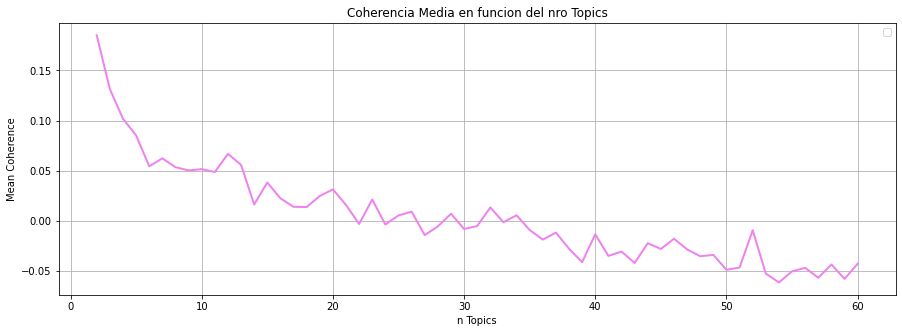

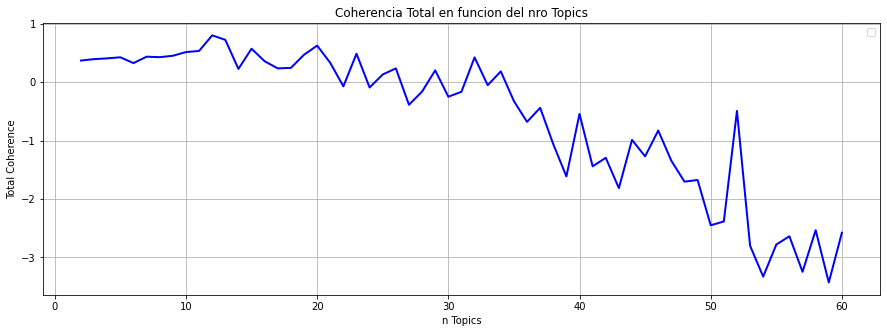

In [ ]:
Tipo_Grafico = "lineas"  ###INGRESE TIPO DE GRAFICO: "barras" o "lineas"

#fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
#plt.subplots(1, 2)

#plt.figure(figsize=[10,4])
for i in range(0,2):
  plt.figure(figsize=[15,5])
  x=N_Topics_array
  if i == 1:
    y=Coherence_Total_array
    title_="Coherencia Total en funcion del nro Topics"
    lable_y="Total Coherence"
    color_="b"
  elif i == 0:
    y=Coherence_Media_array
    title_="Coherencia Media en funcion del nro Topics"
    lable_y="Mean Coherence"
    color_="violet"

  #values = N_Topics_array 

  if Tipo_Grafico == "barras":
    plt.bar(x,y, color=color_, width=0.5)
  elif Tipo_Grafico == "lineas": 
    plt.plot(x,y, color=color_, linewidth=2)

  #plt.plot(pd.DataFrame(Coherence_Total_array, index=N_Topics_array), label='Coherence Total', color="b", linewidth=2)
  plt.title(title_)
  plt.xlabel("n Topics")
  plt.ylabel(lable_y)
  plt.legend()
  #plt.xticks(x,values)
  plt.grid()
  plt.show()
  print(" ")


###***Resultados preliminares del análisis de la cant. óptima de tópicos:***

####***A) Resultados para Datos Totales (sin samplear):***
Nótese, como tanto para la coherencia media como para la total, **se observan picos máximos en alrededor de 19 topics y en 26 topics.** En principio, aplicando un criterio similar al que se aplica para la métrica de Silhouette en la optimización de clusters, **podríamos elegir como las cantidades de tópicos candidatas a ser las óptimas a la de 19 tópicos y a la de 26 tópicos.**

Sin embargo, **un análisis más profundo y de carácter cualitativo será necesario** para confirmar o refutar a estas cantidades óptimas. En este sentido, **proseguiremos con los siguientes pasos:**

***1) Analizaremos la cantidad de “tópicos basura” existentes en cada caso.***

***2) Realizaremos un análisis cualitativo (y subjetivo) del contenido semántico de las top 30 words de cada tópico contenido en dichos casos, antes de tomar una decisión.***

***3) En caso de que los dos análisis anteriores resultaran negativos, volveremos a escoger una cantidad de tópicos candidata a ser óptima de entre los restantetes picos máximos de coherencia media y total, y repetiremos pasos 1) a 3).***

####***B) Resultados para Datos Sampleados:***
Realizamos los mismos análisis anteriores, pero esta vez utilizando una base con datos sampleados, de tal forma de tomar una cantidad constante de registros por año (1812) a partir de 2016 en adelante.
Los resultados han sido bastante diferentes, **apareciendo valores negativos de coherencia** para las cantidades altas de tópicos (a partir de 22 tópicos en adelante).
Si bien estos resultados parecieran no condecir con los obtenidos previamente utilizando los datos totales (no sampleados), sí podemos observar algunas **coincidencias: vuelven a observarse picos máximos alrededor de los 20 topicos y un último pico máximo positivo en 26 tópicos**.  A su vez, **aparece un nuevo pico máximo en 12 tópicos**, que no se detectaba utilizando el total de los datos. 

Preliminarmente, **podríamos pensar que una cantidad de 19 o 20 tópicos podría llegar a ser la óptima, dado que es coincidente tanto para la totalidad de los datos como para el sampleo**. Sin embargo, **esto deberemos validarlo con un análisis cualitativo de los tópicos** y sus words más probables, como hemos ya explicado con los pasos 1) a 3).


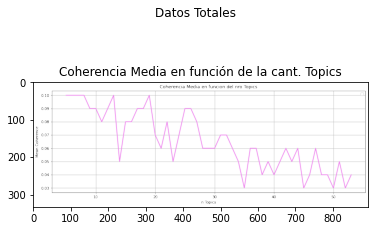

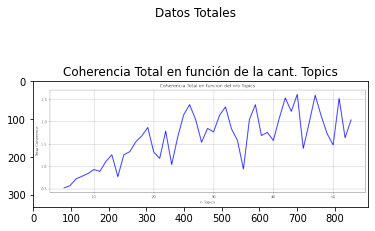

<Figure size 1080x360 with 0 Axes>

'Nótese, como tanto para la coherencia media como para la total, se observan picos máximos en alrededor de 19 topics y en 26 topics. En principio, aplicando un criterio similar al que se aplica para la métrica de Silhouette en la optimización de clusters, podríamos elegir como las cantidades de tópicos candidatas a ser las óptimas a la de 19 tópicos y a la de 26 tópicos. \n   Sin embargo, un análisis más profundo y de carácter cualitativo será necesario para confirmar o refutar a estas cantidades óptimas. En este sentido, proseguiremos con los siguientes pasos: \n    1) Analizaremos la cantidad de “tópicos basura” existentes en cada caso. \n    2) Realizaremos un análisis cualitativo (y subjetivo) del contenido semántico de las top 30 words de cada tópico contenido en dichos casos, antes de tomar una decisión.\n    3) En caso de que los dos análisis anteriores resultaran negativos, volveremos a escoger una cantidad de tópicos candidata a ser óptima de entre los restantetes picos máximo

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


imagen_1_Total = mpimg.imread("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/results/Coherencia_Media_Topics_iteracion_1_topic.png")
imgplot = plt.imshow(imagen_1_Total)
plt.suptitle("Datos Totales")
plt.title("Coherencia Media en función de la cant. Topics")
plt.show()

imagen_2_Total = mpimg.imread("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/results/Coherencia_Total_iteracion_1_topic.png")
imgplot = plt.imshow(imagen_2_Total)
plt.suptitle("Datos Totales")
plt.title("Coherencia Total en función de la cant. Topics")
plt.figure(figsize=[15,5])
plt.show()


#if Tipo_Datos == "sampleados":
 # imagen_1 = imagen_1_Sampleada
#elif Tipo_Datos == "totales":
 # imagen_1 = imagen_1_Total

"""Nótese, como tanto para la coherencia media como para la total, se observan picos máximos en alrededor de 19 topics y en 26 topics. En principio, aplicando un criterio similar al que se aplica para la métrica de Silhouette en la optimización de clusters, podríamos elegir como las cantidades de tópicos candidatas a ser las óptimas a la de 19 tópicos y a la de 26 tópicos. 
   Sin embargo, un análisis más profundo y de carácter cualitativo será necesario para confirmar o refutar a estas cantidades óptimas. En este sentido, proseguiremos con los siguientes pasos: 
    1) Analizaremos la cantidad de “tópicos basura” existentes en cada caso. 
    2) Realizaremos un análisis cualitativo (y subjetivo) del contenido semántico de las top 30 words de cada tópico contenido en dichos casos, antes de tomar una decisión.
    3) En caso de que los dos análisis anteriores resultaran negativos, volveremos a escoger una cantidad de tópicos candidata a ser óptima de entre los restantetes picos máximos de coherencia media y total, y repetiremos pasos 1) a 3).
"""






## **Creación del Modelo Óptimo (con cant. óptima de Topics), gráfico y análisis cualitativo de los Tópicos resultantes:**
### - Utilizaremos la cant. de Tópicos óptima hallada = 19 topicos.
### - Graficaremos con el pyLDAvis del gensim los Topicos hallados.
### - Analizaremos las Top Words de cada uno de los Topicos, para detectar topicos basura e identificar los buenos tópicos encontrados.

In [ ]:
### LDA TOPICS:
# GRAFICO LDA doc2bow:
Tipo_Datos_ = "sampleados"  ### INGRESE DATOS A UTILIZAR: ELIJA: "totales" O "sampleados".
Cant_Optima_Topics = 19     ### INGRESE CANT. OPTIMA DE TOPICOS (En principio: 19, 20, 26, ó 12). 

from pandas.core.describe import describe_categorical_1d
data_Total = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/ACL_data.csv")
data_Sampleada = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/data_clean.csv")

if Tipo_Datos_ == "sampleados":
  data = data_Sampleada
elif Tipo_Datos_ == "totales":
  data = data_Total

if Tipo_Datos_ == "sampleados":
  dataset = data.text.tolist()
elif Tipo_Datos_ == "totales":
  dataset = data.ABSTRACT
  dataset = dataset.tolist()

STOP_WORDS = stopwords.words("english")

def tokenize(x):
    return [word for word in word_tokenize(x) if word not in STOP_WORDS and word.isalpha() and len(word)>1]

if Tipo_Datos_ == "sampleados":
  texts = [word_tokenize(str(doc)) for doc in dataset]
elif Tipo_Datos_ == "totales":
  texts= [tokenize(str(doc).lower()) for doc in dataset]

dictionary = corpora.Dictionary(texts)  #crea diccionario asinandole un indice numerico a cada palabra
dictionary.filter_extremes(no_below=10, no_above=0.5)  #filtra tokens q aparencen en menos de 10 documentos y en mas de la mitad de los documentos.

### doc2bow:
corpus = [dictionary.doc2bow(text) for text in texts] #el bow cuenta cantidad de apariciones de cada palabra del diccionario

#### SETEO DE SEMILLA:
semilla = 420
np.random.seed(semilla)

# LDA realizado con el doc2bow (bolsa de palabras comun)  (NO con TF-IDF):
ldamodel_optimo = LdaModel(corpus=corpus, num_topics=Cant_Optima_Topics, id2word=dictionary, iterations = 200, passes=10, random_state=semilla)

#### COHERENCIAS TOTALES DEL MODELO:
window_size_=10     # INGRESE COHERENCIA WINDOW_SIZE 
coherence_='c_npmi' # INGRESE METRICA DE COHERENCIA 
topn_=30            # INGRESE COHERENCIA TOP WORDS TO EVALUATE. 
ldatopics_optimo = [[word for word, prob in topic] for topicid, topic in ldamodel_optimo.show_topics(Cant_Optima_Topics,formatted=False)]
lda_coherence = CoherenceModel(topics=ldatopics_optimo, texts=texts, dictionary=dictionary, window_size=window_size_,coherence=coherence_,topn=topn_).get_coherence_per_topic()
df_lda = pd.DataFrame([range(Cant_Optima_Topics),lda_coherence,ldatopics_optimo],index=['topic_id','coherence','topic']).transpose()
Coherence_Total = (sum(lda_coherence))
Coherence_Media = (np.mean(lda_coherence))
N_Topics = Cant_Optima_Topics
print('Nro. Topics Optimo: %.2f ' % (N_Topics))
print('Coherencia Media: %.2f ' % (round(np.mean(lda_coherence),2)))
print('Coherencia Total: %.2f ' % (round(sum(lda_coherence),2)))
print(" ")

### GRAFICO DE TOPICOS DEL MODELO:
pyLDAvis.gensim.prepare(ldamodel_optimo, corpus, dictionary)

Nro. Topics Optimo: 19.00 
Coherencia Media: 0.01 
Coherencia Total: 0.19 
 


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.206856  0.068989       1        1  20.068320
13    -0.184161  0.050953       2        1  12.111227
9     -0.138949  0.082048       3        1  10.611284
8     -0.134225  0.003875       4        1   8.812806
5     -0.186684  0.109770       5        1   8.223380
2      0.362844  0.247323       6        1   7.536012
18    -0.161440  0.072927       7        1   7.209816
17    -0.113271  0.102331       8        1   4.387667
4     -0.093600 -0.000228       9        1   3.826021
7     -0.119262  0.024523      10        1   3.751445
3     -0.024229 -0.107821      11        1   2.481728
6     -0.038201 -0.061046      12        1   2.153106
10    -0.019580 -0.109647      13        1   2.128405
15     0.355844  0.252074      14        1   2.016045
11     0.028475 -0.093739      15        1   1.907265
1      0.052269 -0.185992      16        1   1.749866
0      0.193013 -0.196002      17        1   0.369397
16     0.236307 -0.091147      18        1   0.355887
12     0.191705 -0.169190      19        1   0.300327, topic_info=             Term          Freq         Total Category  logprob  loglift
279            de   9968.000000   9968.000000  Default  30.0000  30.0000
286            et   4200.000000   4200.000000  Default  29.0000  29.0000
354         model  11347.000000  11347.000000  Default  28.0000  28.0000
72    translation   6653.000000   6653.000000  Default  27.0000  27.0000
1296       models  10545.000000  10545.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
4979         axes     27.082151     28.098659  Topic19  -5.0441   5.7712
3770      augment    194.108508    225.778826  Topic19  -3.0746   5.6569
4458      adapter     62.974068     73.598170  Topic19  -4.2003   5.6522
2781     messages    157.936017    215.374388  Topic19  -3.2808   5.4979
4201           av     49.077167     71.772933  Topic19  -4.4496   5.4279

[1109 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
6415      8  0.991402  ablation
7722      8  0.986608      absa
144       2  0.051916  abstract
144       7  0.057684  abstract
144      10  0.092295  abstract
...     ...       ...       ...
1563      8  0.021269     years
1563     11  0.001519     years
1563     12  0.006077     years
5710     18  0.962451      york
3834      2  0.990713      zero

[2413 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 14, 10, 9, 6, 3, 19, 18, 5, 8, 4, 7, 11, 16, 12, 2, 1, 17, 13])

### ***Topicos hallados con Datos SAMPLING:***
#### ***-Topic 1: Modelos de ML general ***
#### ***-Topic 2: "Frances?" (stop words, etc.)***
#### ***-Topic 3: Linguistica computacional ***
#### ***-Topic 4: Experimentos ***
#### ***-Topic 5: Language models ***
#### ***-Topic 6: Corpus ***
#### ***-Topic 7: Information retrivial mezcla con Analisis de Sentimiento***
#### ***-Topic 8: sequence to sequence (question anserwing, summarization) 9es un tipo de language model) (transformers q hacen seq2seq usan mask)***
#### ***-Topic 9: machine translation / con un poco de automatic speach recognition (asr) ***
#### ***-Topic 10: Anotacion de corpus (mezcla o anotacion de emotion)***
#### ***-Topic 11: Analisis Gramatical/Sintactico. Grafos para analisis sintactico***
#### ***-Topic 12: Word Embbedings ***
#### ***-Topic 13: Clasificacion de Textos ***
#### ***-Topic 14: Sistema de Dialogo / Chat-Bots. Pero en duda (topico ruidoso, por ej visual, teacher). Topico tecnico. ***
#### ***-Topic 15: NER  ***
#### ***-Topic 16: Redes Neuronales/parafraseo, metafora ???***
#### ***-Topic 17: Multimodal (utilizan mas de un modo (imagen + texto). (va , visual question answering). Pero tambien mete elementos de otras cosas (health, hindi) ***
#### ***-Topic 18:  Analisis de Dialectos ***
#### ***-Topic 19: Transformers ***

In [ ]:
Tipo_Datos_ = "sampleados"  ### INGRESE DATOS A UTILIZAR: ELIJA: "totales" O "sampleados".
Cant_Optima_Topics = 32     ### INGRESE CANT. OPTIMA DE TOPICOS (En principio: 19, 20, 26, ó 12). 

from pandas.core.describe import describe_categorical_1d
data_Total = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/ACL_data.csv")
data_Sampleada = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/data_clean.csv")

if Tipo_Datos_ == "sampleados":
  data = data_Sampleada
elif Tipo_Datos_ == "totales":
  data = data_Total

if Tipo_Datos_ == "sampleados":
  dataset = data.text.tolist()
elif Tipo_Datos_ == "totales":
  dataset = data.ABSTRACT
  dataset = dataset.tolist()

STOP_WORDS = stopwords.words("english")

def tokenize(x):
    return [word for word in word_tokenize(x) if word not in STOP_WORDS and word.isalpha() and len(word)>1]

if Tipo_Datos_ == "sampleados":
  texts = [word_tokenize(str(doc)) for doc in dataset]
elif Tipo_Datos_ == "totales":
  texts= [tokenize(str(doc).lower()) for doc in dataset]

dictionary = corpora.Dictionary(texts)  #crea diccionario asinandole un indice numerico a cada palabra
dictionary.filter_extremes(no_below=10, no_above=0.5)  #filtra tokens q aparencen en menos de 10 documentos y en mas de la mitad de los documentos.

### doc2bow:
corpus = [dictionary.doc2bow(text) for text in texts] #el bow cuenta cantidad de apariciones de cada palabra del diccionario

#### SETEO DE SEMILLA:
semilla = 420
np.random.seed(semilla)

# LDA realizado con el doc2bow (bolsa de palabras comun)  (NO con TF-IDF):
ldamodel_optimo = LdaModel(corpus=corpus, num_topics=Cant_Optima_Topics, id2word=dictionary, iterations = 200, passes=10, random_state=semilla)

#### COHERENCIAS TOTALES DEL MODELO:
window_size_=10     # INGRESE COHERENCIA WINDOW_SIZE 
coherence_='c_npmi' # INGRESE METRICA DE COHERENCIA 
topn_=30            # INGRESE COHERENCIA TOP WORDS TO EVALUATE. 
ldatopics_optimo = [[word for word, prob in topic] for topicid, topic in ldamodel_optimo.show_topics(Cant_Optima_Topics,formatted=False)]
lda_coherence = CoherenceModel(topics=ldatopics_optimo, texts=texts, dictionary=dictionary, window_size=window_size_,coherence=coherence_,topn=topn_).get_coherence_per_topic()
df_lda = pd.DataFrame([range(Cant_Optima_Topics),lda_coherence,ldatopics_optimo],index=['topic_id','coherence','topic']).transpose()
Coherence_Total = (sum(lda_coherence))
Coherence_Media = (np.mean(lda_coherence))
N_Topics = Cant_Optima_Topics
print('Nro. Topics Optimo: %.2f ' % (N_Topics))
print('Coherencia Media: %.2f ' % (round(np.mean(lda_coherence),2)))
print('Coherencia Total: %.2f ' % (round(sum(lda_coherence),2)))
print(" ")

### GRAFICO DE TOPICOS DEL MODELO:
pyLDAvis.gensim.prepare(ldamodel_optimo, corpus, dictionary)

Nro. Topics Optimo: 32.00 
Coherencia Media: -0.00 
Coherencia Total: -0.03 
 


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
31     0.223997  0.119606       1        1  9.226433
26     0.199279  0.148947       2        1  8.408553
15    -0.277072  0.231389       3        1  7.456102
14     0.193865 -0.004561       4        1  7.428021
13     0.178056  0.020938       5        1  7.392130
24     0.194071  0.126804       6        1  6.299934
8      0.157382 -0.090873       7        1  6.164922
28     0.180822 -0.004998       8        1  5.410013
23     0.147326 -0.105135       9        1  4.196766
20     0.125839 -0.044636      10        1  4.083380
5      0.138204  0.020533      11        1  3.920841
9      0.104395 -0.142713      12        1  3.291359
19     0.091914 -0.114150      13        1  3.243387
25     0.084532 -0.046566      14        1  2.842173
18     0.063673  0.212140      15        1  2.564295
3      0.036912 -0.015038      16        1  2.563056
4      0.035321  0.027344      17        1  2.198921
27     0.071129  0.096415      18        1  1.710337
29    -0.276523  0.221826      19        1  1.611594
17    -0.024521 -0.122190      20        1  1.481306
7     -0.014985  0.140474      21        1  1.454245
1     -0.077878 -0.121988      22        1  1.247806
30    -0.034027 -0.120701      23        1  1.168976
10    -0.096034 -0.029064      24        1  0.938881
11    -0.096702 -0.032846      25        1  0.931260
6     -0.113197 -0.112892      26        1  0.895184
21    -0.185435 -0.060054      27        1  0.449021
0     -0.199764 -0.056968      28        1  0.319504
16    -0.226042  0.026060      29        1  0.297003
2     -0.202407 -0.056846      30        1  0.294973
12    -0.203925 -0.055809      31        1  0.265706
22    -0.198206 -0.054448      32        1  0.243914, topic_info=             Term          Freq         Total Category  logprob  loglift
354         model  11509.000000  11509.000000  Default  30.0000  30.0000
279            de  10106.000000  10106.000000  Default  29.0000  29.0000
286            et   4187.000000   4187.000000  Default  28.0000  28.0000
72    translation   6541.000000   6541.000000  Default  27.0000  27.0000
32      languages   6013.000000   6013.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
5021      fouille     46.526349     52.176718  Topic32  -4.2949   5.9015
1008    intuition     42.909175     80.808730  Topic32  -4.3758   5.3831
1451      support    176.957742   1002.541735  Topic32  -2.9590   4.2817
4254          acc     29.217741     58.248474  Topic32  -4.7601   5.3262
3816  observation     23.622435     99.920173  Topic32  -4.9727   4.5739

[1820 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
6415     20  0.993388     ablation
7722     20  0.991513         absa
6018      5  0.990148  abstraction
7641      8  0.996736  abstractive
7510     23  0.995564      abusive
...     ...       ...          ...
1563     12  0.026035        years
1563     14  0.091887        years
1563     23  0.047475        years
1563     26  0.001531        years
3834      6  0.987935         zero

[4439 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[32, 27, 16, 15, 14, 25, 9, 29, 24, 21, 6, 10, 20, 26, 19, 4, 5, 28, 30, 18, 8, 2, 31, 11, 12, 7, 22, 1, 17, 3, 13, 23])

In [ ]:
### LDA TOPICS:
# GRAFICO LDA doc2bow:
Tipo_Datos_ = "totales"  ### INGRESE DATOS A UTILIZAR: ELIJA: "totales" O "sampleados".
Cant_Optima_Topics = 19     ### INGRESE CANT. OPTIMA DE TOPICOS (En principio: 19, 20, 26, ó 12). 

from pandas.core.describe import describe_categorical_1d
data_Total = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/ACL_data.csv")
data_Sampleada = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/data_clean.csv")

if Tipo_Datos_ == "sampleados":
  data = data_Sampleada
elif Tipo_Datos_ == "totales":
  data = data_Total

if Tipo_Datos_ == "sampleados":
  dataset = data.text.tolist()
elif Tipo_Datos_ == "totales":
  dataset = data.ABSTRACT
  dataset = dataset.tolist()

STOP_WORDS = stopwords.words("english")

def tokenize(x):
    return [word for word in word_tokenize(x) if word not in STOP_WORDS and word.isalpha() and len(word)>1]

if Tipo_Datos_ == "sampleados":
  texts = [word_tokenize(str(doc)) for doc in dataset]
elif Tipo_Datos_ == "totales":
  texts= [tokenize(str(doc).lower()) for doc in dataset]

dictionary = corpora.Dictionary(texts)  #crea diccionario asinandole un indice numerico a cada palabra
dictionary.filter_extremes(no_below=10, no_above=0.5)  #filtra tokens q aparencen en menos de 10 documentos y en mas de la mitad de los documentos.

### doc2bow:
corpus = [dictionary.doc2bow(text) for text in texts] #el bow cuenta cantidad de apariciones de cada palabra del diccionario

#### SETEO DE SEMILLA:
semilla = 420
np.random.seed(semilla)

# LDA realizado con el doc2bow (bolsa de palabras comun)  (NO con TF-IDF):
ldamodel_optimo = LdaModel(corpus=corpus, num_topics=Cant_Optima_Topics, id2word=dictionary, iterations = 200, passes=10, random_state=semilla)

#### COHERENCIAS TOTALES DEL MODELO:
window_size_=10     # INGRESE COHERENCIA WINDOW_SIZE 
coherence_='c_npmi' # INGRESE METRICA DE COHERENCIA 
topn_=30            # INGRESE COHERENCIA TOP WORDS TO EVALUATE. 
ldatopics_optimo = [[word for word, prob in topic] for topicid, topic in ldamodel_optimo.show_topics(Cant_Optima_Topics,formatted=False)]
lda_coherence = CoherenceModel(topics=ldatopics_optimo, texts=texts, dictionary=dictionary, window_size=window_size_,coherence=coherence_,topn=topn_).get_coherence_per_topic()
df_lda = pd.DataFrame([range(Cant_Optima_Topics),lda_coherence,ldatopics_optimo],index=['topic_id','coherence','topic']).transpose()
Coherence_Total = (sum(lda_coherence))
Coherence_Media = (np.mean(lda_coherence))
N_Topics = Cant_Optima_Topics
print('Nro. Topics Optimo: %.2f ' % (N_Topics))
print('Coherencia Media: %.2f ' % (round(np.mean(lda_coherence),2)))
print('Coherencia Total: %.2f ' % (round(sum(lda_coherence),2)))
print(" ")

### GRAFICO DE TOPICOS DEL MODELO:
pyLDAvis.gensim.prepare(ldamodel_optimo, corpus, dictionary)

"""RESULTADOS DATOS SAMPLEADOS:
Nro. Topics Optimo: 19.00 
Coherencia Media: 0.02 
Coherencia Total: 0.47"""

"""RESULTADOS DATOS TOTALES:
Nro. Topics Optimo: 19.00 
Coherencia Media: 0.07 
Coherencia Total: 1.42"""
"""NOTESE QUE CON DATOS TOTALES LA COHERENCIA DA 3 VECES MAS ALTA"""

Nro. Topics Optimo: 19.00 
Coherencia Media: 0.07 
Coherencia Total: 1.42 
 


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.180009  0.030154       1        1  13.462073
13     0.124109 -0.108522       2        1  11.480302
10     0.181562  0.152360       3        1  10.989782
8      0.091313 -0.062162       4        1   7.254461
15     0.143621  0.123657       5        1   6.373918
4      0.118338  0.080654       6        1   6.338963
1      0.142503  0.085317       7        1   5.606648
17     0.112663 -0.056089       8        1   5.400532
14    -0.317079  0.099134       9        1   5.300180
2      0.096378  0.009436      10        1   5.179580
3      0.116912  0.011727      11        1   5.167387
0      0.048990 -0.209331      12        1   4.838526
7     -0.012438 -0.092775      13        1   3.203060
16    -0.007423  0.094065      14        1   2.715511
5     -0.127281 -0.107954      15        1   2.030601
11    -0.166648 -0.305019      16        1   1.547020
6     -0.142476  0.012138      17        1   1.417428
18    -0.288356  0.109584      18        1   0.867240
12    -0.294699  0.133626      19        1   0.826789, topic_info=             Term          Freq         Total Category  logprob  loglift
4831           de  12451.000000  12451.000000  Default  30.0000  30.0000
1518  translation  12316.000000  12316.000000  Default  29.0000  29.0000
122          word   9594.000000   9594.000000  Default  28.0000  28.0000
25       language  22937.000000  22937.000000  Default  27.0000  27.0000
97          model  24071.000000  24071.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
630            et   1765.676062   5667.242569  Topic19  -2.4908   3.6292
2962       genres    249.897000    413.491608  Topic19  -4.4460   4.2918
854      examples    454.777214   1709.799185  Topic19  -3.8473   3.4711
614    robustness    183.739892    554.587180  Topic19  -4.7536   3.6907
428       samples    151.071474    709.973768  Topic19  -4.9493   3.2479

[1176 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
5006      1  0.994927  abbreviations
868       3  0.993948           absa
439       4  0.994710        abusive
1622      1  0.190517         access
1622      2  0.259103         access
...     ...       ...            ...
123      17  0.000777           work
1938      4  0.996547        workers
5977     16  0.996554       workflow
4552      7  0.996293            wsd
7876      2  0.997933            xml

[2928 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 14, 11, 9, 16, 5, 2, 18, 15, 3, 4, 1, 8, 17, 6, 12, 7, 19, 13])

### ***Topicos hallados con Datos TOTALES:***
#### ***-Topic 1: Modelos de ML para Lenguaje ?????***
#### ***-Topic 2: Evaluacion/Clasificacion Automatica de Textos ?????***
#### ***-Topic 3: Sistemas Generativos de Texto ????***
#### ***-Topic 4: Analisis del Lenguaje ????***
#### ***-Topic 5: Modelos ML de Analisis de Lenguaje ????***
#### ***-Topic 6: Scrapping ???? ***
#### ***-Topic 7: Word Embbedings ?***
#### ***-Topic 8: Traduccion automatica ?????***
#### ***-Topic 9: "Topico Basura": stop words, etc***
#### ***-Topic 10: Analisis Gramatical/Sintactico ?????***
#### ***-Topic 11: Clasificacion de Textos ????***
#### ***-Topic 12: Lexicons ???***
#### ***-Topic 13: Analisis de Sentimiento ok!***
#### ***-Topic 14: Chat-Bots ????***
#### ***-Topic 15: Analisis del Discurso ???***
#### ***-Topic 16: Bases de Datos/Recursos ???***
#### ***-Topic 17: Analisis multimodal o de imagenes ???***
#### ***-Topic 18: "Basura": stop words y palabras extranjeras???***
#### ***-Topic 19: "Basura"***

### ***Resultados, Conclusiones:***
###-Para una cantidad optima de 19 Topicos, ***los Datos Sampleados obtuvieron tan solo 2/19 topicos basura***; mientras ***los Datos Totales obtuvieron 3/19 topicos basura.***
###-A su vez, ***los Datos Sampleados detectaron claramente el Topico "Transformers"***; mientras ***los Datos Totales no pudieron identificarlo.***
###-Hay varios topicos identificados en ambos modelos.
###-Podriamos ***concluir que, a priori y para 19 topicos, los Datos Sampleados dan mejores resultados que usar el Total de los Datos sin sampleo.***


In [ ]:
##### ****DE ACA PARA ABAJO HAY CODIGO QUE SALIO MAL O QUE NO FUE VERIFICADO AUN**** #####

In [ ]:
###### ACA INTENTO GRAFICAR LOS TOPICS COMO HACE EL SKLEARN PERO PARA GENSIM, SIN EXITO AUN: XXXX

cant_topics = 10 #### INGRESE CANTIDAD TOPICS

import math
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#from sklearn.decomposition import NMF, MiniBatchNMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_components = cant_topics
n_top_words = 30
batch_size = 128
init = "nndsvda"

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(math.ceil(cant_topics/5), 5, figsize=(35, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

tf_vectorizer = count_vect

tf_feature_names = tf_vectorizer.get_feature_names_out()

plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")


In [ ]:
print('Max Coherence Total: %.2f ' % (Max_Coherence))
print('N Topics Total Optimo: %.2f ' % (Max_Topic))
print(" ")


Max Coherence Total: 2.65 
N Topics Total Optimo: 40.00 
 


In [ ]:
Max_Coherence

2.646271142888884

NameError: ignored

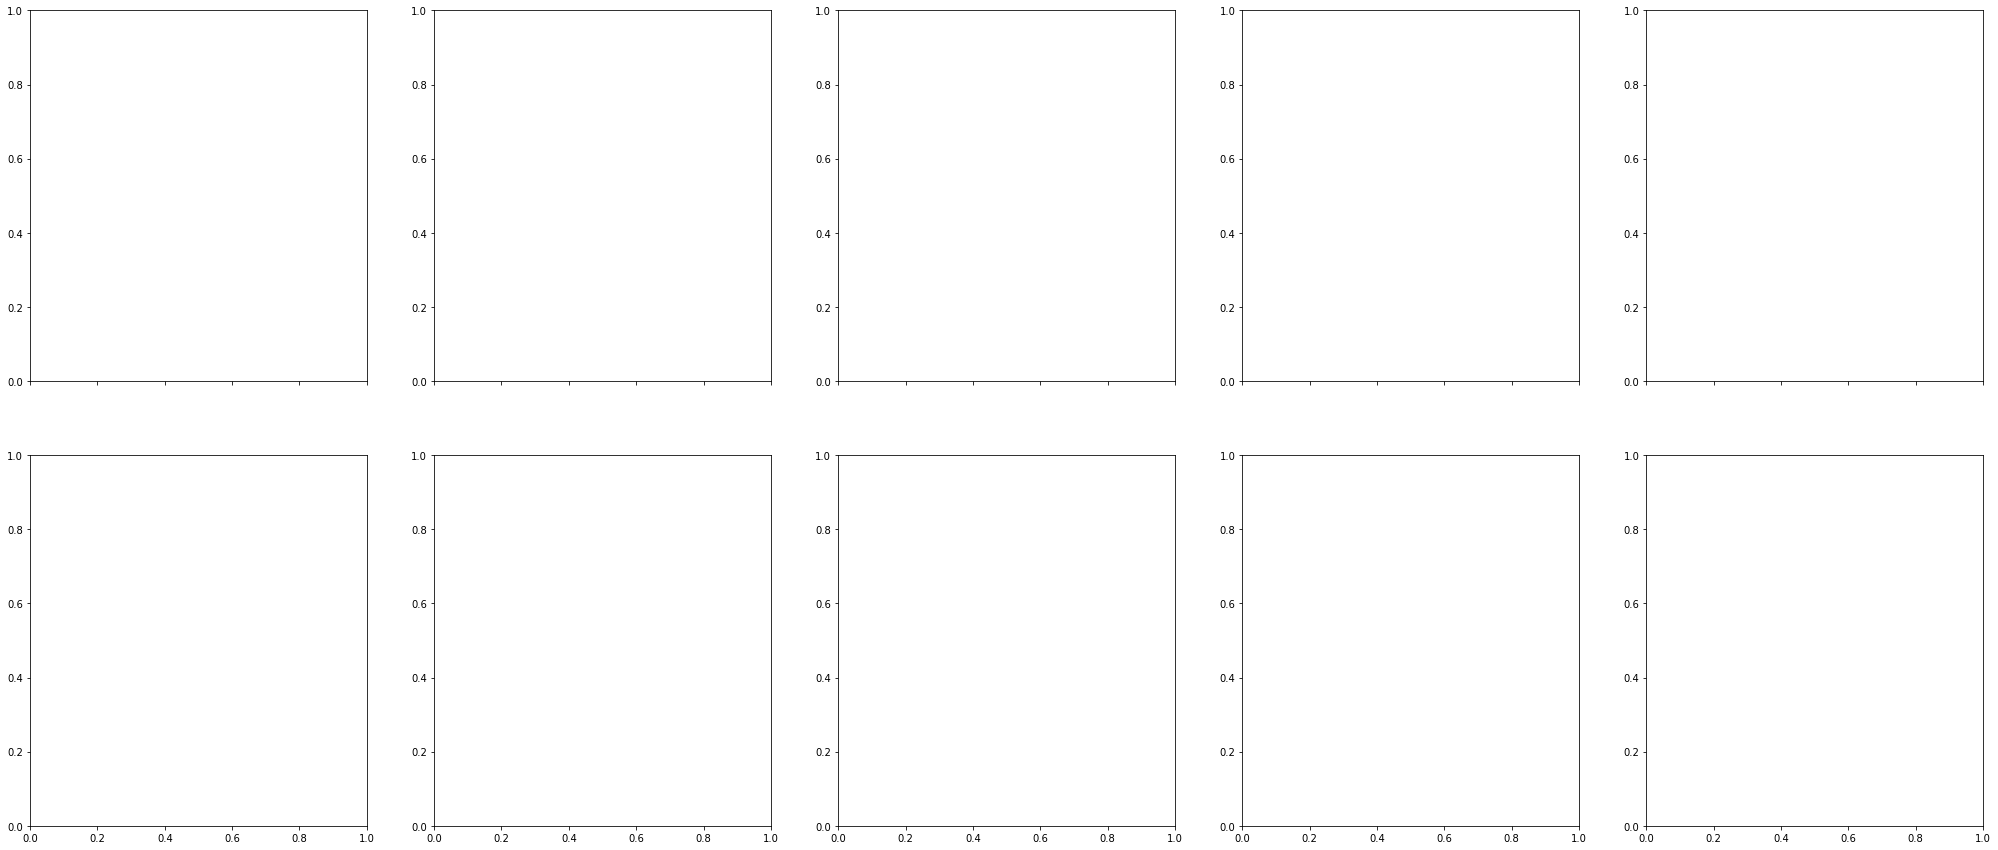

In [ ]:
n_topics = 2
title = "Coherence - n Topics: " + str(n_topics)
  #fig, ax = plt.subplots(figsize = (2.5, 4))
fig, axes = plt.subplots(2, 5, figsize=(35, 15), sharex=True)
pd.Series({'LDA':sum(lda_coherence),}).plot.bar(title=title, ylim=(0,2.0), color=["blue"])
print('n Topics: %.2f ' % (n_topics))
print('LDA Mean Coherence: %.2f ' % (round(np.mean(lda_coherence),2)))
print('LDA Total Coherence: %.2f ' % (round(sum(lda_coherence),2)))

In [ ]:
df_lda.sort_values(by='coherence',ascending=False)

,topic_id,coherence,topic
5,5,0.555076,"[de, des, la, les, et, un, le, une, nous, en]"
1,1,0.257901,"[translation, machine, system, mt, systems, la..."
2,2,0.198918,"[semantic, parsing, syntactic, annotation, dep..."
6,6,0.158358,"[sentiment, social, analysis, news, detection,..."
7,7,0.085927,"[models, model, data, training, language, perf..."
8,8,0.080812,"[verbs, linguistic, verb, et, lexical, bias, s..."
0,0,0.052261,"[word, languages, words, language, paper, lexi..."
9,9,0.05089,"[model, information, knowledge, question, prop..."
4,4,0.026575,"[task, system, features, paper, model, results..."
3,3,0.02495,"[language, corpus, data, paper, research, syst..."


In [ ]:
df_tf_idf.sort_values(by='coherence',ascending=False)

,topic_id,coherence,topic
4,4,0.568605,"[de, des, la, les, un, le, une, nous, et, en]"
6,6,0.254704,"[translation, mt, system, machine, systems, ev..."
0,0,0.231611,"[social, news, media, sentiment, analysis, fea..."
9,9,0.227263,"[dialogue, dialog, conversation, user, convers..."
3,3,0.155374,"[task, subtask, shared, system, tweets, emotio..."
2,2,0.042644,"[model, models, word, tasks, learning, knowled..."
8,8,-0.161693,"[nan, annotation, corpus, resources, lexical, ..."
1,1,-0.363209,"[ud, afips, hpsg, attachment, amharic, ashingt..."
5,5,-0.400593,"[privacy, hyperpartisan, tl, gender, bridging,..."
7,7,-0.428394,"[gec, bibliography, urdu, poetry, attacks, att..."
